In [2]:
from scipy.io import wavfile
from pylab import*
import pandas as pd
import matplotlib.pyplot as plt                          
%matplotlib inline                                       

In [3]:
# 1 == AbNormal, 0 == Normal
def loadData(trainingFolder):
    wav = pd.read_csv('{}/REFERENCE.csv'.format(trainingFolder), header=None, names =['filename', 'outcome'])
    wav_list = []
    wav_name = []
    
    wav.outcome.replace(to_replace=-1, value=0, inplace=True)
    
    for fname in wav.filename:
        path = "{}/{}.wav".format(trainingFolder, fname)
        sampFreq, snd = wavfile.read(path)                  # Return the sample rate (in samples/sec) and data from a WAV file.
        snd = snd/(2.**14)                                  # Normalization //2**14 = 16384
        wav_list.append(snd)
        wav_name.append(fname)
    return wav_list, wav

In [4]:
def shortenTo9Sec(sndList):
    snd9SecList = []
    for snd in sndList:
        sndNP = np.asarray(snd)
        if sndNP.size <= 16384:
            #print("Case0")
            snd9sec = sndNP
        #Check left and rigth side of max index
        # max is at least 8000 from start and 8000 from end
        elif sndNP.argmax() > 8000 and (sndNP.size - sndNP.argmax()) >= 8000:   
            #print("Case1")
            snd9sec = snd[sndNP.argmax() - 8000:sndNP.argmax()+8000]         #cut it 8000 left right around max
        # max is within 8000 from start
        elif sndNP.argmax() < 8000 and sndNP.size - sndNP.argmax() > 8000:
            #print("Case2") 
            snd9sec = sndNP[0:16000]                                         #cut it 16000 from front
        # max is at least 8000 from start but within 8000 from end
        elif sndNP.argmax() > 8000 and sndNP.size - sndNP.argmax() <= 8000:
            #print("Case3")
            snd9sec = sndNP[sndNP.size - 16000:sndNP.size]                   #cut it 16000 from end
    
        snd9SecList.append(snd9sec)
    return snd9SecList

In [5]:
def maverage(snd, offset):
    aveList = []
    for x in range(0,len(snd)-offset+1):
        aveList.append(np.mean((snd[x:x+offset])))
    return aveList

In [6]:
def average(snd, offset):
    aveList = []
    for x in range(0,len(snd), offset):
        aveList.append(np.mean(snd[x:x+offset]))
    return aveList

In [7]:
def fftProcess4(sndList, cutOffidx, offset):
    sndFFTList = []
    fList = []                                    
    NFFT = 16384                                  # NFFT can be any positive value, but FFT computations are typically much more efficient when the number of samples can be factored into small primes.
    Fs = 2000                                     # Fs = Sampling rate
    for idx, snd in enumerate(sndList):
        L = len(snd)                              # L : length of signal.
        Ypre = fft(snd, NFFT)/L                   # specify begin & end of signal=fft(wavefile)/length of signal.
        Y = 2*np.abs(Ypre[0:NFFT//2])             # FFT computing & normallization. 
        sndFFTList.append(average(Y[0:cutOffidx], 4))
        #sndFFTList.append(maverage(Y[0:cutOffidx], 4))
        f = Fs/2*np.linspace(0.0, 1, NFFT//2+1)   # f = sampling rate/2*pts --(linspace(start,end,Number))
        fList.append(f)
    return sndFFTList, fList

### Training D

In [8]:
sndDMList, wavDMDF = loadData('training-d_cleaned')
sndDM9SecList = shortenTo9Sec(sndDMList)
fftDMList, fDMList = fftProcess4(sndDM9SecList, 2458, 4) #set at 300Hz?

In [20]:
[(ele.shape,ele2.shape,len(fdm),out) for ele,ele2,fdm,out in zip(sndDMList,sndDM9SecList,fftDMList,wavDMDF.outcome)][:10]

#sndDMList ,sndDM9SecList, length(fftDMList), wave outcome-Normal/AbNormal 

[((13215,), (13215,), 615, 0),
 ((21693,), (16000,), 615, 1),
 ((22080,), (16000,), 615, 1),
 ((19028,), (16000,), 615, 1),
 ((18835,), (16000,), 615, 0),
 ((13816,), (13816,), 615, 0),
 ((25560,), (16000,), 615, 0),
 ((59580,), (16000,), 615, 1),
 ((24811,), (16000,), 615, 1),
 ((24095,), (16000,), 615, 1)]

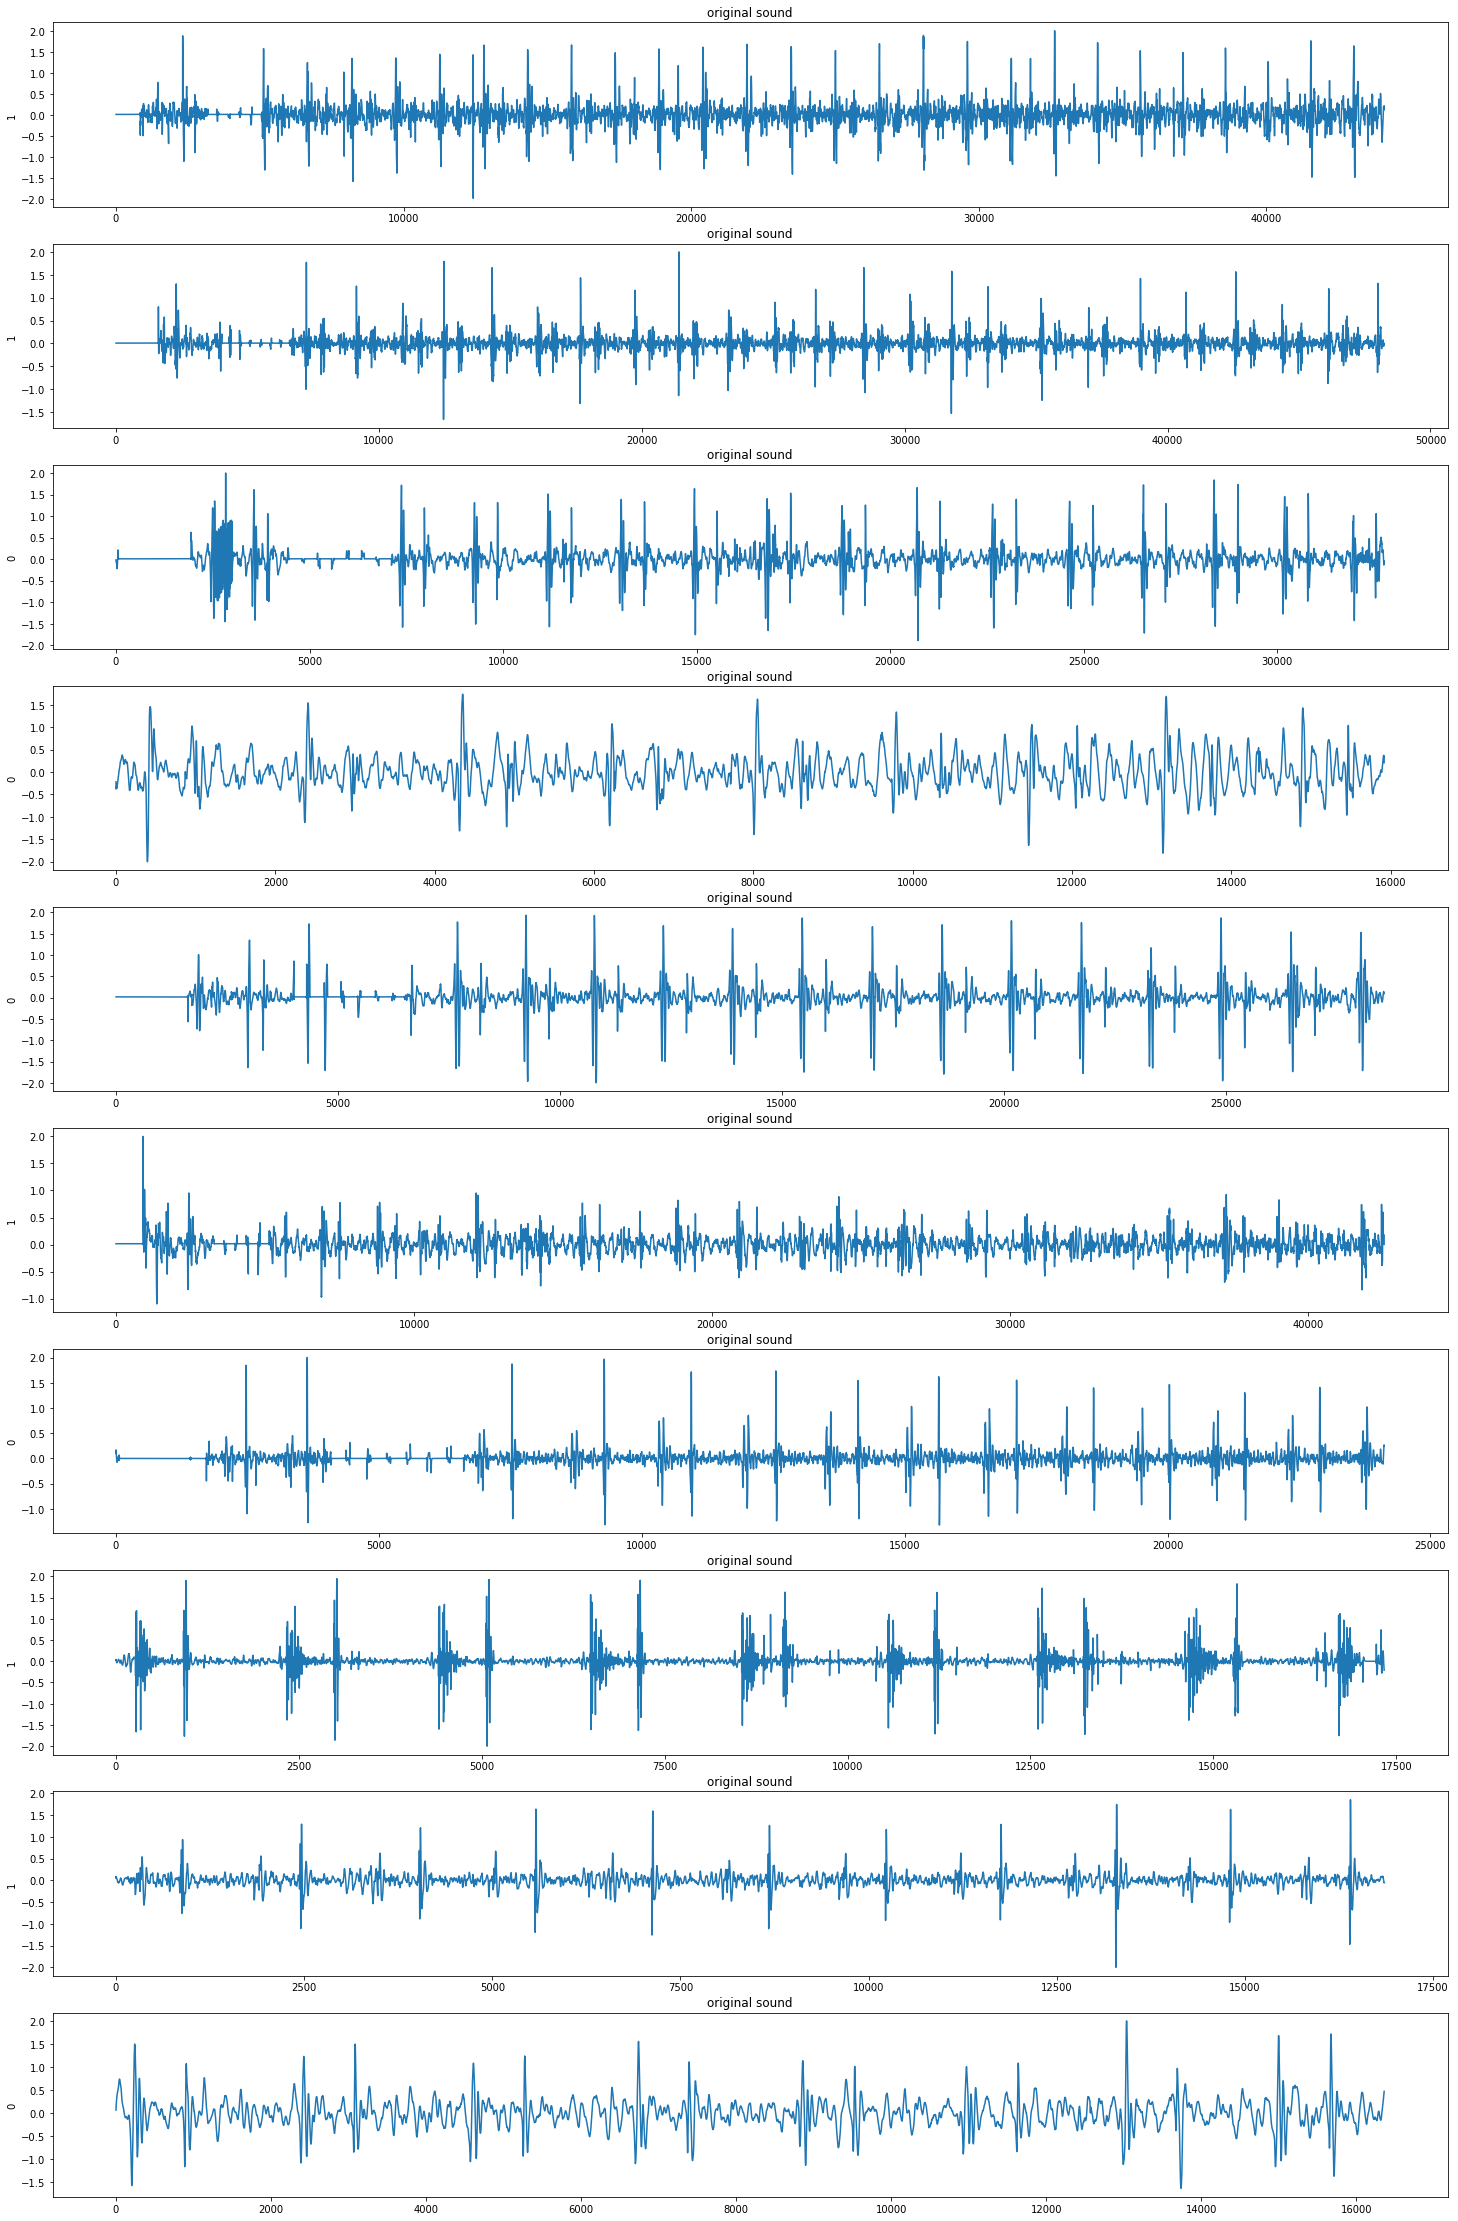

In [18]:
#wave befor processing
#idx=[0,1,4,5,6,7,8,9,10,11,12,13,14,15]
idx = range(20,30)
n=len(idx)

plt.figure(figsize=(25,n*4))
plt.title("original sound signal")
for i,idi in enumerate(idx):
    plt.subplot(n,1,i+1)
    plt.plot(sndDMList[idi])
    plt.ylabel(wavDMDF.outcome[idi])
    plt.title("original sound")


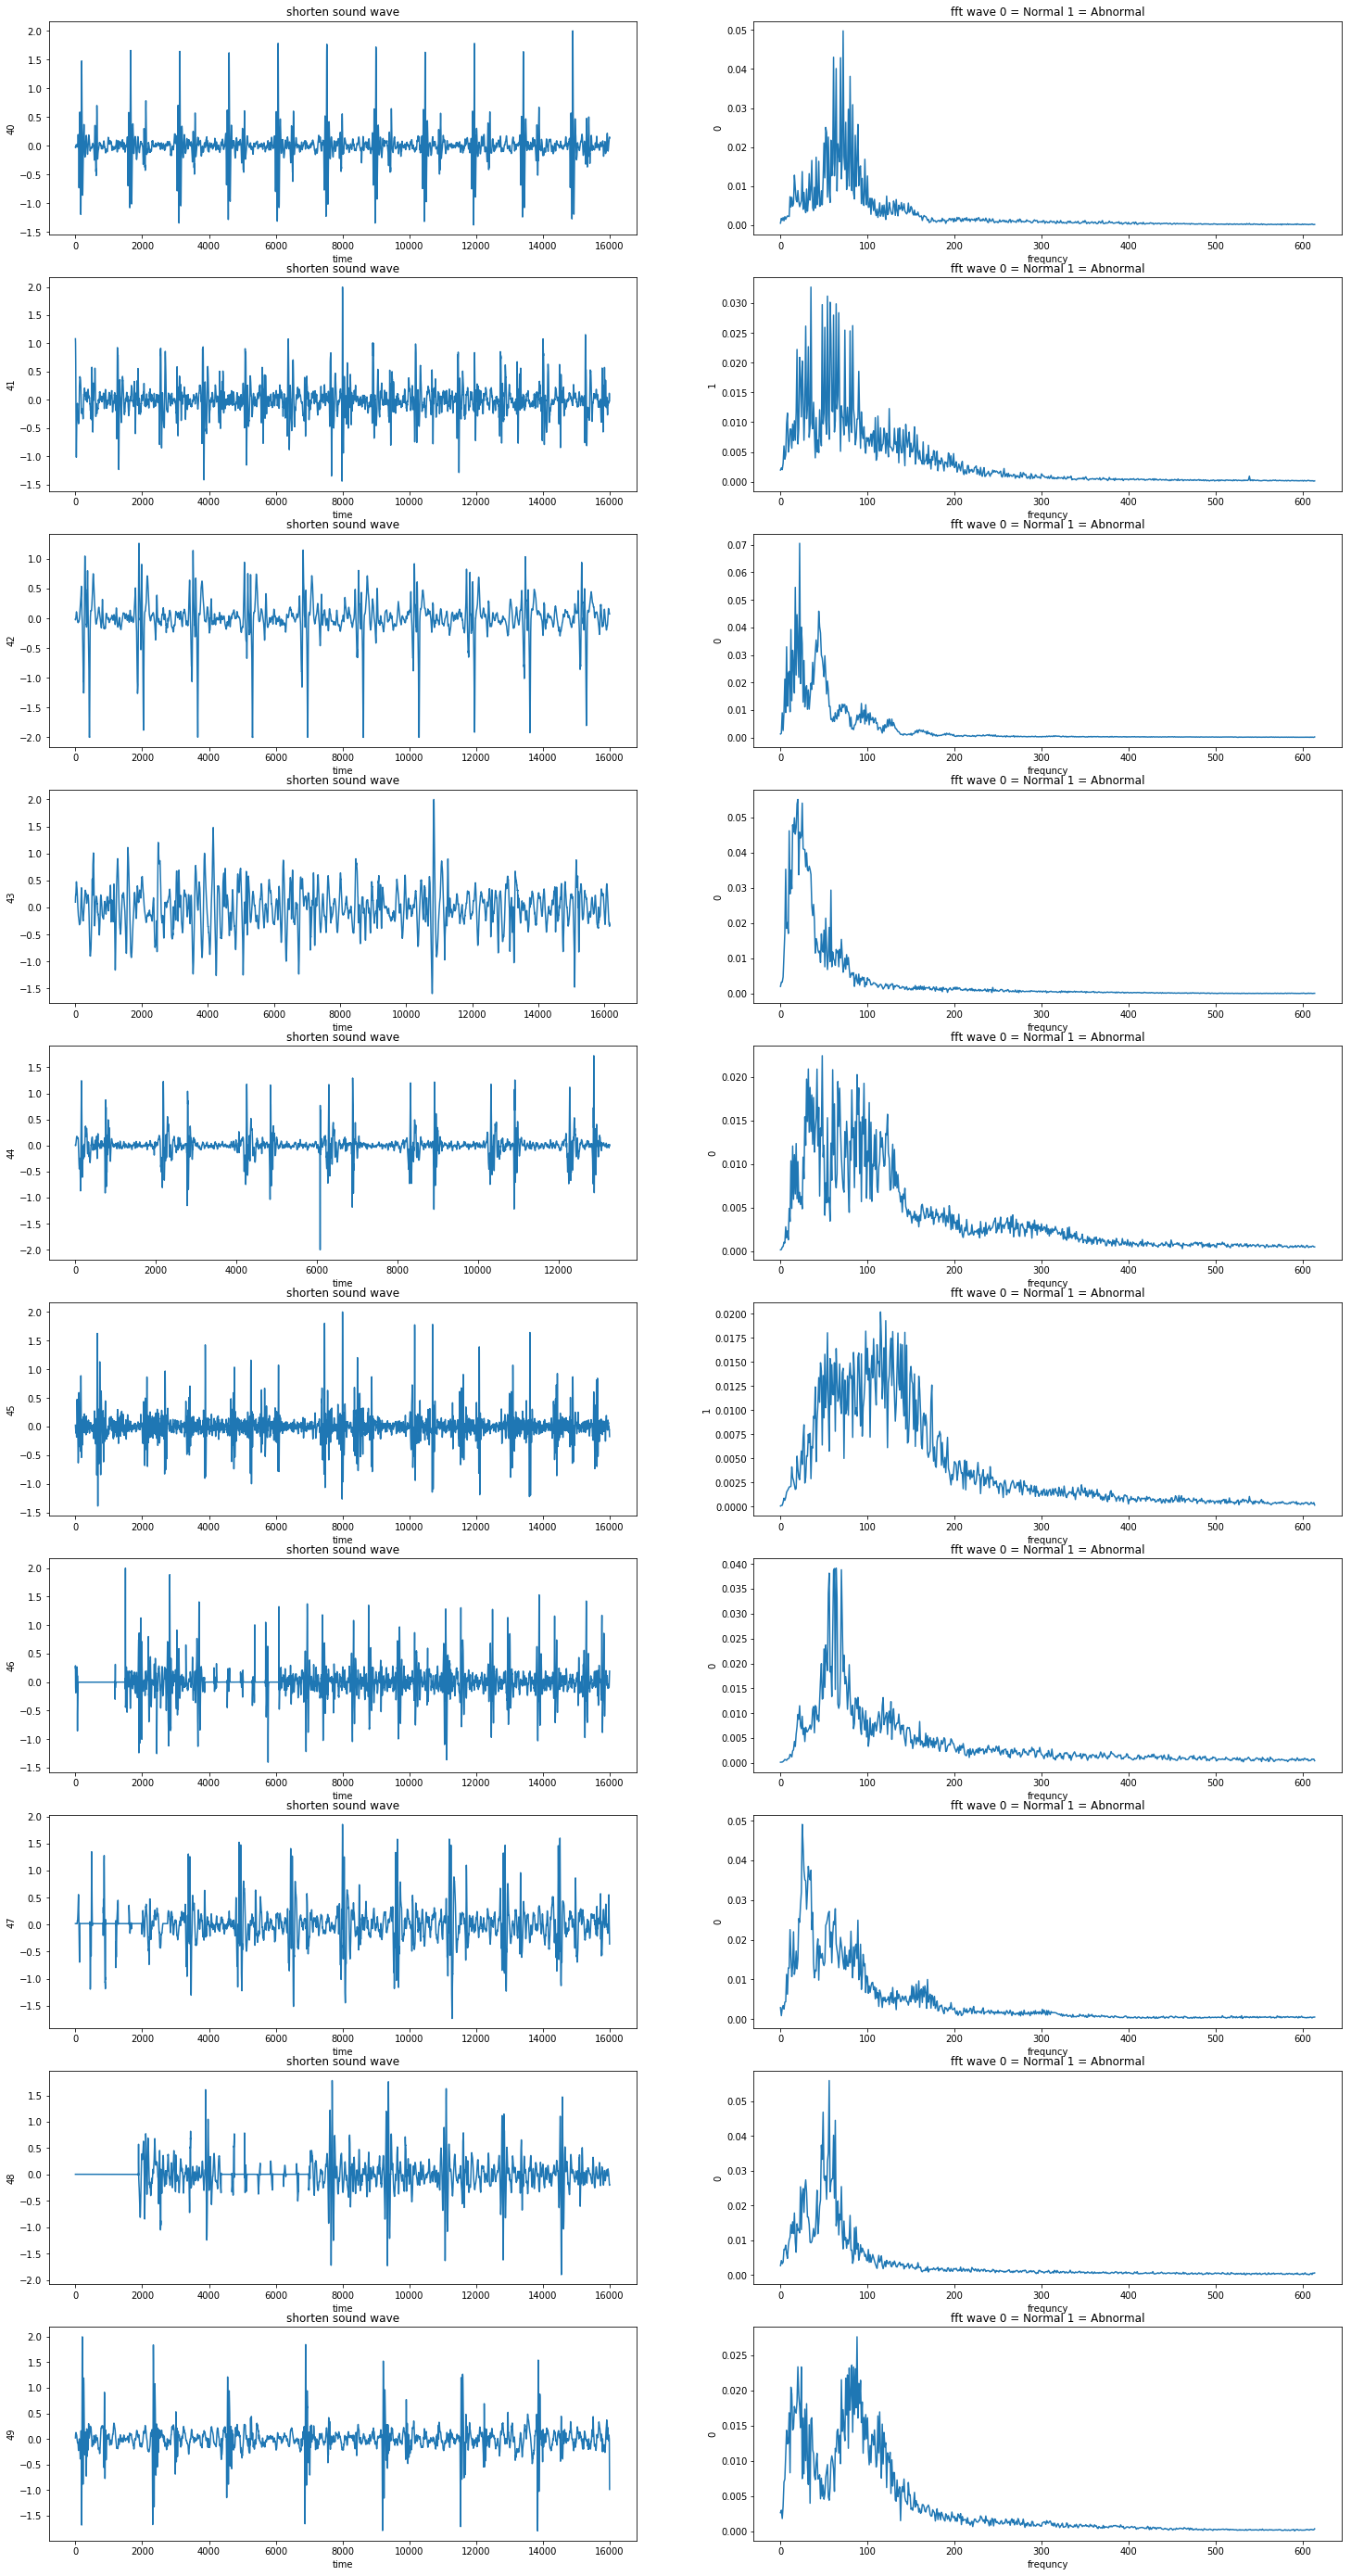

In [16]:
#wave after processing
#idx=[0,1,4,5,6,7,8,9]
idx = range(40,50)
n=len(idx)
plt.figure(figsize=(25,n*5))
plt.title("wave after processing")
for i,idi in enumerate(idx):
    plt.subplot(n,2,2*i+1)
    plt.plot(sndDM9SecList[idi])
    plt.ylabel(idi)
    plt.xlabel("time")
    plt.title("shorten sound wave")
    plt.subplot(n,2,2*i+2)
    plt.plot(fftDMList[idi])
    plt.ylabel(wavDMDF.outcome[idi])
    plt.xlabel("frequncy")
    plt.title("fft wave 0 = Normal 1 = Abnormal")

### Training A

In [14]:
sndAMList, wavAMDF = loadData('training-a_cleaned')
sndAM9SecList = shortenTo9Sec(sndAMList)
fftAMList, fAMList = fftProcess4(sndAM9SecList, 2458, 4) 

### Training B

In [15]:
sndBMList, wavBMDF = loadData('training-b_cleaned')
sndBM9SecList = shortenTo9Sec(sndBMList)
fftBMList, fBMList = fftProcess4(sndBM9SecList, 2458, 4) 

### Training C

In [16]:
sndCMList, wavCMDF = loadData('training-c_cleaned')
sndCM9SecList = shortenTo9Sec(sndCMList)
fftCMList, fCMList = fftProcess4(sndCM9SecList, 2458, 4) 

### Training E

In [17]:
sndEMList, wavEMDF = loadData('training-e_cleaned')
sndEM9SecList = shortenTo9Sec(sndEMList)
fftEMList, fEMList = fftProcess4(sndEM9SecList, 2458, 4) 

### Bidirectional lstm

Bidirectional lstm is for sequence classification problems.

lstm : Long Short Term Memory.
    
It involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side, 
then providing the input sequence as-is as input to the first layer and providing a reversed copy of the input sequence to the second.

Dense, Dropout -> core layer , 
LSTM -> Recurrent layer , 
Embedding -> Embedding layer , 
Bidirectional -> Layer wrapper

In [18]:
from __future__ import print_function
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

/home/priya/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [19]:
max_features = 1000
maxlen = 100

### E Model for Training

In [20]:
EM_arr=np.array(fftEMList)
x_train = EM_arr.reshape(len(EM_arr),615,1)         # reshape : Gives a new shape to an array without changing its data.
y_train_list=wavEMDF.outcome.tolist()
y_train=np.array(y_train_list)
x_train.shape

(2141, 615, 1)

### D Model for Testing

In [21]:
DM_arr=np.array(fftDMList) 
x_test = DM_arr.reshape(len(DM_arr),                # reshape : Gives a new shape to an array without changing its data.
                        615,                        # newshape : The new shape should be compatible with the original shape. 
                        1)                          # order : Read the elements of a using this index order, and place the elements into the reshaped array using this index order.
y_test_list=wavDMDF.outcome.tolist()
y_test=np.array(y_test_list)


In [22]:
print(x_test.shape)
print(y_test.shape)                                        # Calculate No of rows

(55, 615, 1)
(55,)


In [23]:
sndVALList, wavVALDF = loadData('validation')
sndVAL9SecList = shortenTo9Sec(sndVALList)

fftVALList, fVALList = fftProcess4(sndVAL9SecList, 2458, 4)

VALarr=np.array(fftVALList)
x_test = VALarr.reshape(len(VALarr),615,1)
y_test_list=wavVALDF.outcome.tolist()
y_test=np.array(y_test_list)

In [24]:
model = Sequential()                                  # Sequential model.

# Adding Layers using method add
model.add(Bidirectional(LSTM(64)))                    #64 memory point in lstm model
model.add(Dropout(0.5))                               # Applies Dropout to the input.
                                                      # A Simple Way to Prevent Neural Networks from Overfitting.
model.add(Dense(units = 1, activation ='sigmoid'))     # Dense(Output space dimension, Activation).
                                                      # sigmoid function -> predict outcomes as YES/NO (1/0).

# Compilation                                         # Configures the model for training.
model.compile( optimizer = 'adam',                    # Adam: A Method for Stochastic Optimization.
               loss = 'binary_crossentropy',          # Used if outcomes are in 1/0 form.
               metrics = ['accuracy'])                               

print('Train...')
model.fit(x_train,y_train,
          batch_size = 32,                            # Batch_size = 32 (By default)
          epochs = 4,                                 # epoch -> Iteration on dataset
          validation_data=[x_test, y_test]
         )

Train...
Train on 2141 samples, validate on 301 samples
Epoch 1/4
2141/2141 [==============================] - 35s 17ms/step - loss: 0.3982 - acc: 0.9099 - val_loss: 1.2265 - val_acc: 0.4983
Epoch 2/4
2141/2141 [==============================] - 33s 15ms/step - loss: 0.2968 - acc: 0.9145 - val_loss: 1.1947 - val_acc: 0.4983
Epoch 3/4
2141/2141 [==============================] - 33s 16ms/step - loss: 0.2998 - acc: 0.9145 - val_loss: 1.1826 - val_acc: 0.4983
Epoch 4/4
2141/2141 [==============================] - 33s 16ms/step - loss: 0.2970 - acc: 0.9145 - val_loss: 1.2332 - val_acc: 0.4983
